In [1]:
import numpy as np
from neuralStellar import *
import pymc3 as pm
import corner
import theano.tensor as T
import scipy
import corner

In [14]:
m1=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m1.loadModel('Ran_files/small_grid_30/small_grid_model.h5')
m1.getWeights()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense_15 (Dense)             (None, 32)                160       
_________________________________________________________________
dense_16 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_17 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_18 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_19 (Dense)             (None, 3)                 99        
Total params: 3,427
Trainable params: 3,427
Non-trainable params: 0
_________________________________________________________

In [12]:
file='grid_0_0.csv'
small_grid=stellarGrid(file)
small_grid.buildIndex()
small_grid.popIndex(['','star_mass','star_age','star_feh',None,'star_MLT','effective_T','luminosity','delta_nu'])
small_grid.initialData()


iso_ages=np.array([3.6])
#iso_ages=10**np.linspace(np.log10(0.1),np.log10(8),30)
age_width=0.1 #0.05
iso_feh=0
iso_MLT=1.9
Teffs = []
Ls = []
delnus = []
masses = []
ages = []
for d in small_grid.data:
    if d[small_grid.indices['age']] > iso_age-age_width and d[small_grid.indices['age']] < iso_age+age_width:
        Teffs.append(d[small_grid.indices['Teff']])
        Ls.append(d[small_grid.indices['L']])
        delnus.append(d[small_grid.indices['delnu']])
        masses.append(d[small_grid.indices['mass']])
        ages.append(d[small_grid.indices['age']])
print(len(ages))
Teffs = Teffs[:35]
Ls = Ls[:35]
delnus = delnus[:35]
masses = masses[:35]
ages = ages[:35]

Data headers = 
['', 'model_number', 'star_mass', 'star_age', 'star_feh', 'star_MLT', 'star_fov', 'effective_T', 'luminosity', 'radius', 'log_g', 'surface_h1', 'surface_he4', 'center_h1', 'center_he4', 'log_center_T', 'log_center_Rho', 'he_core_mass', 'delta_nu', 'delta_Pg', 'nu_max', 'nu_0_10', 'nu_0_11', 'nu_0_12', 'nu_0_13', 'nu_0_14', 'nu_0_15']
250


[-3.6478823  1.1356968] [[3.19980606e-04 3.02489968e-05]
 [3.02489968e-05 1.30245413e-05]]
[0.017888   0.00360895]


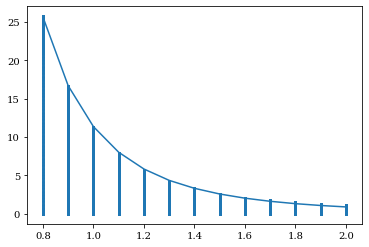

In [13]:
x_in = small_grid.fetchData('evo',['mass','age'])

to_fit=[[],[]]
std_lifetimes=[]
for track in small_grid.evo_tracks:
    this_m = track[0][small_grid.indices['mass']]
    max_age = max(track[:,small_grid.indices['age']])
    to_fit[0].append(this_m)
    to_fit[1].append(max_age)
    MS_lifetime = 10*this_m**-3
    #print(this_m,max_age,MS_lifetime, max_age/MS_lifetime)

def lifetime_func(M, alpha, f):
    return f*(10*M**alpha)

fits, pcov = scipy.optimize.curve_fit(lifetime_func, to_fit[0], to_fit[1])
print(fits, pcov)
print(np.sqrt(np.diag(pcov)))

plt.scatter(10**x_in[0],10**x_in[1],s=3)
plt.plot(to_fit[0],lifetime_func(to_fit[0],*fits))
plt.show()

In [16]:
#age mean - lognormal
Age_mu_mu = 4.5
Age_mu_sigma = 0.1
#age sigma - half normal
Age_sigma_sigma = 0.1

N = len(Teffs)

model = pm.Model()
with model:
    Age_lb = pm.Normal('lb_age', 3.5, 0.2)
    Age_range = pm.Lognormal('range_age', T.log(0.2), 0.5)
    Age = pm.Deterministic('age', pm.Beta('b',1.1,1.1,shape=N)*Age_range+Age_lb)
    M = pm.Deterministic('mass', pm.Beta('c',1.1,1.1,shape=N)*(1.35-0.8)+0.8)
    
    feh = pm.Deterministic('feh',T.zeros(N))
    MLT = pm.Deterministic('MLT',T.ones(N)*1.9)
    
    obs = pm.Deterministic('obs',m1.manualPredict([T.log10(M), T.log10(Age), feh, MLT]))
    
    obs_L = pm.Normal('obs_L',10**obs[0],0.1, observed=Ls)
    obs_Teff = pm.Normal('obs_Teff',10**obs[1],70, observed=Teffs)
    obs_delnu = pm.Normal('obs_delnu',10**obs[2],0.1, observed=delnus)

[Elemwise{log10,no_inplace}.0, Elemwise{log10,no_inplace}.0, feh, MLT]


In [17]:
start = {'lb_age': 3.5, 'range_age': 0.2}
with model:
    #trace = pm.sample(init='adapt_diag', start=start)
    trace = pm.sample(tune=5000, init='adapt_diag', start=start, target_accept=0.99, cores=1, chains=1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [c, b, range_age, lb_age]


Only one chain was sampled, this makes it impossible to run some convergence checks


In [19]:
pm.summary(trace, var_names=['lb_age','range_age','mass','age'])

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape valida

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 500), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
lb_age,3.629,0.052,3.533,3.724,0.005,0.004,95.0,95.0,98.0,152.0,NaN
range_age,0.202,0.094,0.061,0.363,0.012,0.009,57.0,52.0,77.0,84.0,NaN
mass[0],0.825,0.001,0.823,0.826,0.000,0.000,140.0,140.0,161.0,96.0,NaN
mass[1],0.825,0.001,0.824,0.827,0.000,0.000,168.0,168.0,225.0,100.0,NaN
mass[2],0.899,0.001,0.897,0.901,0.000,0.000,231.0,231.0,268.0,184.0,NaN
mass[3],0.900,0.001,0.898,0.902,0.000,0.000,385.0,385.0,392.0,208.0,NaN
mass[4],0.899,0.001,0.897,0.901,0.000,0.000,159.0,159.0,211.0,125.0,NaN
mass[5],0.900,0.001,0.898,0.902,0.000,0.000,200.0,200.0,206.0,255.0,NaN
mass[6],0.994,0.002,0.991,0.997,0.000,0.000,334.0,334.0,344.0,293.0,NaN
mass[7],0.996,0.002,0.993,1.000,0.000,0.000,294.0,294.0,298.0,332.0,NaN


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x0000012005629C50>,
      dtype=object)

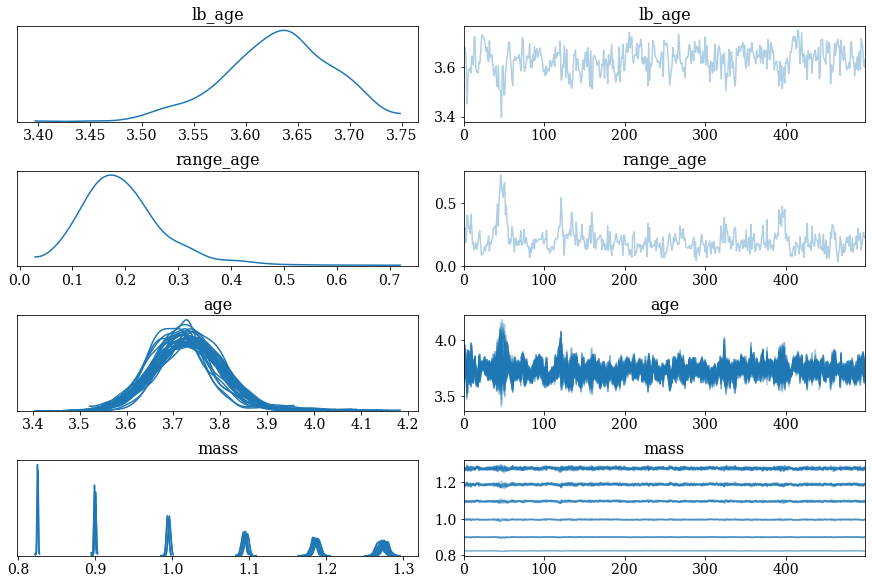

In [21]:
#pm.plots.traceplot(trace,var_names=['mean_age','spread_age'])
pm.plots.traceplot(trace,var_names=['lb_age','range_age','age','mass'],compact=True)

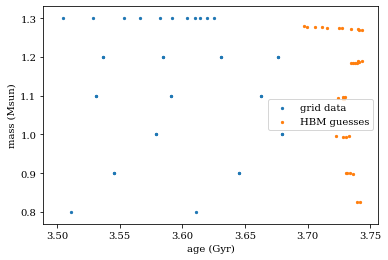

(500, 35)


In [22]:
mean_masses=[]
mean_ages=[]
for i,m in enumerate(trace['mass'].T):
    mean_masses.append(np.mean(m))
    mean_ages.append(np.mean(trace['age'].T[i]))
plt.scatter(ages,masses,s=5, label='grid data')
plt.scatter(mean_ages,mean_masses,s=5,label='HBM guesses')
plt.xlabel('age (Gyr)')
plt.ylabel('mass (Msun)')
plt.legend()
plt.show()
print(np.shape(trace['mass']))

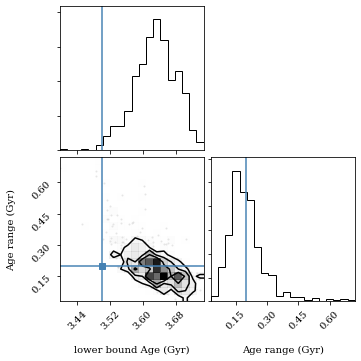

In [25]:
corner.corner(np.array([trace['lb_age'], trace['range_age']]).T, truths=[3.5,0.2], labels=['lower bound Age (Gyr)','Age range (Gyr)']);

In [29]:
m2=NNmodel('evo',['mass','age','feh','MLT'],['L','Teff','delnu'])
m2.loadModel('Ran_files/small_grid_28/small_grid_model.h5')
m2.getWeights()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
dense (Dense)                (None, 128)               640       
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 128)               16512 

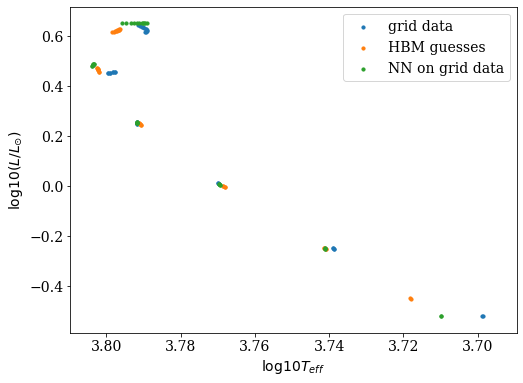

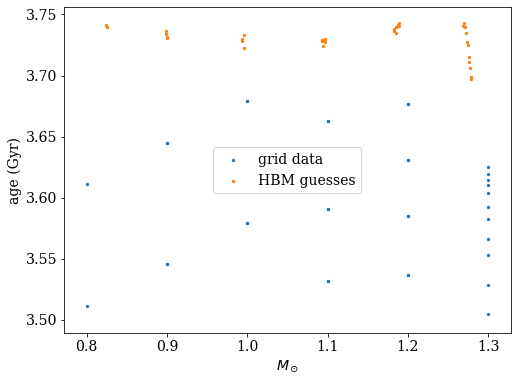

In [35]:
from matplotlib import rc
rc("font", family="serif", size=14)
mean_ages=np.mean(trace['age'],axis=0)
mean_masses = np.mean(trace['mass'],axis=0)
Finputs = np.log10(np.vstack((mean_masses, mean_ages, 10**np.zeros(N), 10**(np.ones(N)*1.9))))
Foutputs = m1.model.predict(Finputs.T).T
[FL, FTeff, Fdelnu] = 10**Foutputs
Tinputs = np.log10(np.vstack((masses, ages, 10**np.zeros(N), 10**(np.ones(N)*1.9))))
Toutputs = m1.model.predict(Tinputs.T).T
[TL, TTeff, Tdelnu] = 10**Toutputs
fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(np.log10(Teffs), np.log10(Ls), s=10, label='grid data')
ax.scatter(np.log10(FTeff), np.log10(FL), s=10, label='HBM guesses')
ax.scatter(np.log10(TTeff), np.log10(TL), s=10, label='NN on grid data')
ax.set_xlim(ax.get_xlim()[::-1])
ax.set_xlabel(r'$\log10 T_{eff}$')
ax.set_ylabel(r'$\log10(L/L_{\odot})$')
ax.legend()
plt.show()

fig, ax=plt.subplots(1,1,figsize=[8,6])
ax.scatter(masses, ages,s=5, label='grid data')
ax.scatter(mean_masses, mean_ages, s=5, label='HBM guesses')
ax.set_xlabel(r'$M_\odot$')
ax.set_ylabel(r'age (Gyr)')
ax.legend()
plt.show()

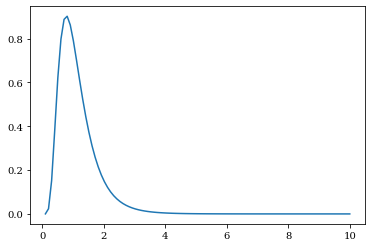

In [23]:
x=np.linspace(0,10,100)
mu=np.log(1)
sigma=0.5
y=(1/x)/(sigma*np.sqrt(2*np.pi))*np.exp(-(np.log(x)-mu)**2/(2*sigma**2))
plt.plot(x,y)